# NN2: Implementacja propagacji wstecznej błędu
Adrianna Grudzień 


<!-- Teoria:\
http://neuralnetworksanddeeplearning.com/chap2.html \
https://towardsdatascience.com/implementing-backpropagation-with-style-in-python-da4c2f49adb4 -->

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import random
import time
import networkx as nx

In [3]:
square_simple_train = pd.read_csv("mio1/regression/square-simple-training.csv", index_col=0)
square_simple_test = pd.read_csv("mio1/regression/square-simple-test.csv", index_col=0)
steps_small_train = pd.read_csv("mio1/regression/steps-small-training.csv", index_col=0)
steps_small_test = pd.read_csv("mio1/regression/steps-small-test.csv", index_col=0)
multimodal_large_train = pd.read_csv("mio1/regression/multimodal-large-training.csv")
multimodal_large_test = pd.read_csv("mio1/regression/multimodal-large-test.csv")

### Pomocnicze funkcje

In [4]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def arrays2tuples(x_array, y_array):
    """
    Tworzy listę krotek (x, y) składających się z poszczególnych obserwacji.
    """
    arr = []
    for i in range(1,len(x_array)):
        arr.append((x_array[i], y_array[i]))
    return arr

def tuples2arrays(tuples_arr):
    """
    Tworzy listę krotek (x, y) składających się z poszczególnych obserwacji.
    """
    x_arr = []
    y_arr = []
    for i in range(len(tuples_arr)):
        x_arr.append(tuples_arr[i][0])
        y_arr.append(tuples_arr[i][1])
    return [x_arr, y_arr]

def normalize_data(data):
    """data (array)"""
    return (data - np.min(data)) / (np.max(data) - np.min(data))

### Definicja sieci
- **sizes**: *array[int]* \
liczba neuronów w kolejnych warstwach

In [5]:
class Network:
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
  
#         # Xavier method
#         # inicjalizacja wag:
#         weights = []
#         for i in range(1,len(sizes)):
#             # number of nodes in the previous layer
#             n = self.sizes[i-1]
#             weights.append(np.random.uniform(-1/np.sqrt(n),1/np.sqrt(n),[sizes[i], sizes[i-1]]))
#         #inicjalizacja biasów:
#         biases = []
#         for i in range(1, len(sizes)):
#             n = self.sizes[i-1]
#             biases.append(np.random.uniform(-1/np.sqrt(n),1/np.sqrt(n),[sizes[i],1]))
        
#         self.weights = weights
#         self.biases = biases
        
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
        self.mse = [] # mse


    def feedforward(self, x):
        x = np.matrix(x)
        for b, w in zip(self.biases, self.weights):
            x = sigmoid(np.dot(w, x)+b)
        return x
    
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.back_propagate(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.weights = [w-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]
        
        
    def train(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):    
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                mse = metrics.mean_absolute_error(self.feedforward(np.matrix(tuples2arrays(test_data)[0])), np.matrix(tuples2arrays(test_data)[1]))
                self.mse.append(mse)
                
    def back_propagate(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward 
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
 
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

### Wizualizacja wartości wag - definicja funkcji
(z użyciem pakietu **networkx**)

In [6]:
def show_weighted_graph(network, weights):
    G=nx.Graph()

    # rysowanie węzłów:
    for layer in range(len(network.sizes)):
        for neuron in range(network.sizes[layer]):
            G.add_node((layer,neuron), pos=(layer, neuron))

    # rysowanie krawędzi:
    for layer in range(len(network.sizes)-2):
    #     print(layer)
        for neuron1 in range(network.sizes[layer]):
            for neuron2 in range(network.sizes[layer+1]):
                if weights[layer].shape[1] == 1:
                    weight = weights[layer][neuron2]
                else:
                    weight = weights[layer][neuron1][neuron2]
                G.add_edge((layer,neuron1), (layer+1,neuron2), weight=np.round(weight,3))

    layer = len(net.sizes)-2 # nr przedostatniej warstwy
    for neuron1 in range(network.sizes[layer+1]):
        for neuron2 in range(network.sizes[layer]):
            if weights[layer].shape[1] == 1:
                weight = weights[layer][neuron2]
            else:
                weight = weights[layer][neuron1][neuron2]
            G.add_edge((layer+1,neuron1), (layer,neuron2), weight=np.round(weight,3))

    labels = nx.get_edge_attributes(G,'weight')
    pos = (nx.get_node_attributes(G, 'pos'))
    nx.draw(G, pos)

    edge_labels = nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

## Zbiór `square-simple`

In [7]:
x = square_simple_train['x']
y = normalize_data(square_simple_train['y'])

x_test = square_simple_test['x']
y_test = normalize_data(square_simple_test['y'])

Wagi sprzed treningu:

MSE:  0.42786835946675184


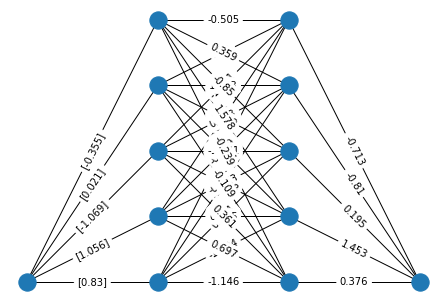

In [8]:
net = Network([1,5,5,1])
show_weighted_graph(net, net.weights)
print('MSE: ', metrics.mean_absolute_error(net.feedforward(x), np.matrix(y)))

Trening i wagi po treningu:

training time:  904.9339318275452 s
MSE:  0.03133525213915476


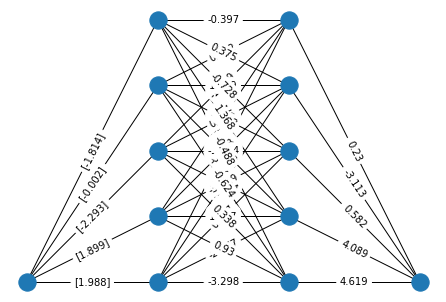

In [10]:
start = time.time()
net.train(arrays2tuples(x,y), np.int(1e5), 2, 1e-3, arrays2tuples(x_test,y_test))
end = time.time()
print('training time: ', end - start, 's')
show_weighted_graph(net, net.weights)
print('MSE: ', metrics.mean_absolute_error(net.feedforward(x), np.matrix(y)))

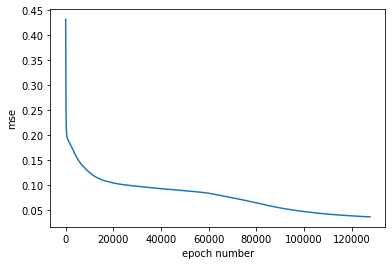

In [11]:
plt.plot(np.arange(len(net.mse)), net.mse)
plt.ylabel("mse")
plt.xlabel("epoch number")
plt.show()

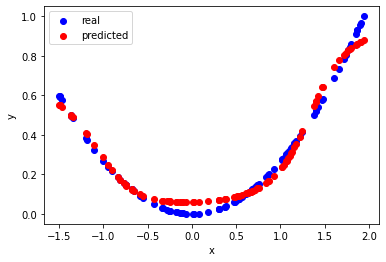

In [12]:
y_pred = net.feedforward(np.matrix(x))

plt.scatter(x,y, color='blue')
plt.scatter(x,np.array(y_pred.flatten()), color='red')
plt.legend(['real', 'predicted'])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Zbiór `steps-small`

In [13]:
x = steps_small_train['x']
y = normalize_data(steps_small_train['y'])

x_test = steps_small_test['x']
y_test = normalize_data(steps_small_test['y'])

Wagi sprzed treningu:

MSE:  0.3719937765921307


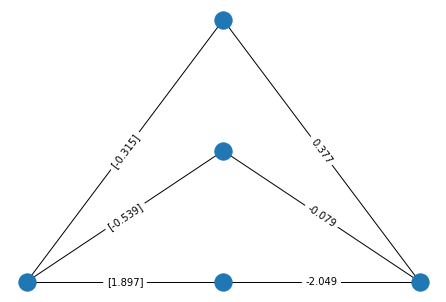

In [14]:
net = Network([1,3,1])
show_weighted_graph(net, net.weights)
print('MSE: ', metrics.mean_absolute_error(net.feedforward(x), np.matrix(y)))

Trening i wagi po treningu:

training time:  374.45302844047546 s
MSE:  0.09202001834315178


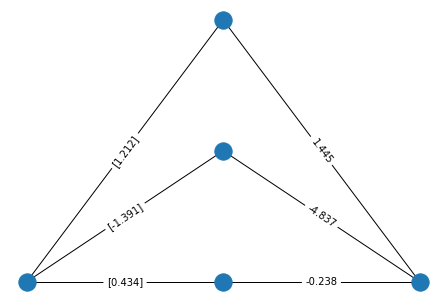

In [15]:
start = time.time()
net.train(arrays2tuples(x,y), np.int(1e5), 2, 1e-3, arrays2tuples(x_test,y_test))
end = time.time()
print('training time: ', end - start, 's')
show_weighted_graph(net, net.weights)
print('MSE: ', metrics.mean_absolute_error(net.feedforward(x), np.matrix(y)))

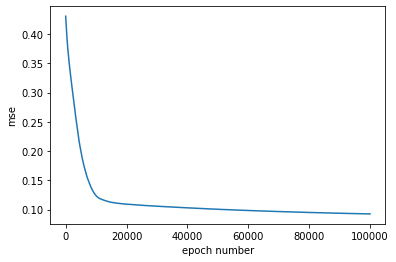

In [16]:
plt.plot(np.arange(len(net.mse)), net.mse)
plt.ylabel("mse")
plt.xlabel("epoch number")
plt.show()

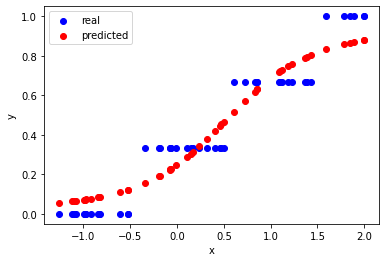

In [17]:
y_pred = net.feedforward(np.matrix(x))

plt.scatter(x,y, color='blue')
plt.scatter(x,np.array(y_pred.flatten()), color='red')
plt.legend(['real', 'predicted'])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Zbiór `multimodal-large`

In [18]:
x = multimodal_large_train['x']
y = normalize_data(multimodal_large_train['y'])

x_test = multimodal_large_test['x']
y_test = normalize_data(multimodal_large_test['y'])

Wagi sprzed treningu:

MSE:  0.39450062396440716


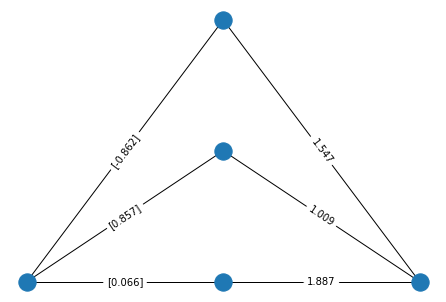

In [19]:
net = Network([1,3,1])
show_weighted_graph(net, net.weights)
print('MSE: ', metrics.mean_absolute_error(net.feedforward(x), np.matrix(y)))

Trening i wagi po treningu:

training time:  496.2127740383148 s
MSE:  0.11010380653463363


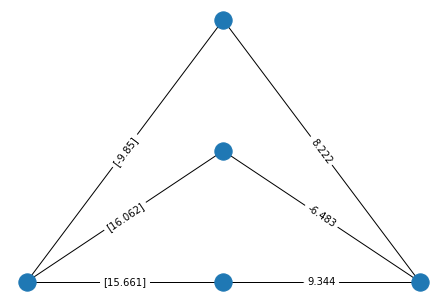

In [21]:
start = time.time()
net.train(arrays2tuples(x,y), np.int(1e3), 2, 1e-3, arrays2tuples(x_test,y_test))
end = time.time()
print('training time: ', end - start, 's')
show_weighted_graph(net, net.weights)
print('MSE: ', metrics.mean_absolute_error(net.feedforward(x), np.matrix(y)))

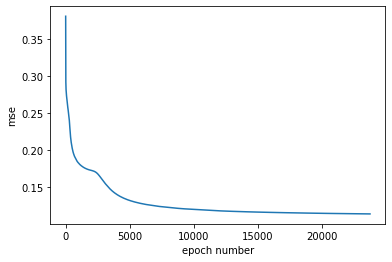

In [22]:
plt.plot(np.arange(len(net.mse)), net.mse)
plt.ylabel("mse")
plt.xlabel("epoch number")
plt.show()

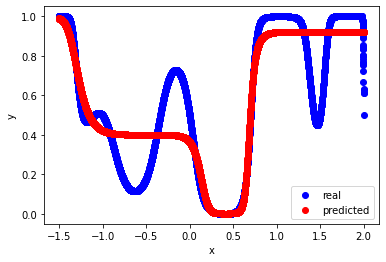

In [23]:
y_pred = net.feedforward(np.matrix(x))

plt.scatter(x,y, color='blue')
plt.scatter(x,np.array(y_pred.flatten()), color='red')
plt.legend(['real', 'predicted'])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Nie zdążyłam odnormalizować danych:(